In [0]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Lambda, Dense, Activation, Input, AveragePooling2D, Flatten, Dropout
from tensorflow.nn import local_response_normalization
from IPython.display import SVG
import IPython
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import sklearn 
from tensorflow.keras.applications import imagenet_utils
import random
from imutils import paths
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from tensorflow.keras import models

*Today i will implement the InceptionNet version 1 based on this wonderful and  specific architecture from medium* 


![alt text](https://mk0learnfx6ydjq1jij.kinstacdn.com/wp-content/uploads/2019/09/1_53uKkbeyzJcdo8PE5TQqqw-1-1024x700.png)

Mong la khong fail :v

In [0]:
def LocResNorm(X):
  X = local_response_normalization(X)
  return X
def Inception_module(X, filters):
  X_conv1 = X
  X_conv3 = X
  X_conv5 = X
  X_pool = X
  F1_conv1_1, F1_conv1_3, F2_conv3, F1_conv1_5, F2_conv5, F2_conv1 = filters
  X_conv1 = Conv2D(F1_conv1_1, kernel_size = (1,1), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X_conv1)
  X_conv1 = Activation("relu")(X_conv1)
  X_conv3 = Conv2D(F1_conv1_3, kernel_size=(1,1), padding = "same", kernel_initializer= glorot_uniform(seed = 0))(X_conv3)
  X_conv3 = Activation("relu")(X_conv3)
  X_conv3 = Conv2D(F2_conv3, kernel_size= (3,3), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X_conv3)
  X_conv3 = Activation("relu")(X_conv3)
  X_conv5 = Conv2D(F1_conv1_5, kernel_size=(1,1), padding = "same", kernel_initializer= glorot_uniform(seed = 0))(X_conv5)
  X_conv5 = Activation("relu")(X_conv5)
  X_conv5 = Conv2D(F2_conv5, kernel_size= (5,5), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X_conv5)
  X_conv5 = Activation("relu")(X_conv5)
  X_pool = MaxPooling2D(pool_size=(3,3), padding = "same", strides = (1,1))(X_pool)
  X_pool = Activation("relu")(X_pool)
  X_pool = Conv2D(F2_conv1, kernel_size= (1,1), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X_pool)
  X_pool = Activation("relu")(X_pool)
  X = Concatenate(axis = 3)([X_conv1, X_conv3, X_conv5, X_pool])
  return X
def Stem_module(X, filters):
  F_conv7, F_conv1, F_conv3 = filters
  X = Conv2D(F_conv7, kernel_size = (7,7), strides = (2,2), kernel_initializer= glorot_uniform(seed = 0), padding = "same")(X)
  X = Activation("relu")(X)
  X = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding= "same")(X)
  X = LocResNorm(X)
  X = Conv2D(F_conv1, kernel_size=(1,1), padding = "valid", strides = (1,1), kernel_initializer=glorot_uniform(seed = 0))(X)
  X = Activation("relu")(X)
  X = Conv2D(F_conv3, kernel_size=(3,3), kernel_initializer = glorot_uniform(seed = 0), strides = (1,1), padding = "same")(X)
  X = Activation("relu")(X)
  X = LocResNorm(X)
  X = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "valid")(X)
  return X
def Auxiliary_module(X, filter, classes, name):
  X = AveragePooling2D(pool_size = (5,5), strides = (3,3), padding = "valid")(X)
  X = Conv2D(filter, kernel_size = (1,1), strides = (1,1), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Flatten()(X)
  X = Dense(512, activation = "relu", kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dense(classes, kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Activation("softmax", name = name)(X)
  return X

In [0]:
def GoogleNet_v1(input_shape, classes):
  X_input = Input(input_shape, sparse = False)
  X = Stem_module(X_input, [64,64,192])
  X = Inception_module(X, [64, 96, 128, 16, 32, 32])
  X = Inception_module(X, [128, 128, 192, 32, 96, 64])
  X = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "same")(X)
  X = Inception_module(X, [192, 96, 208, 16, 48, 64])
  X_aux1 = X
  softmax_0 = Auxiliary_module(X_aux1, 128, 10, "aux1")
  X = Inception_module(X, [160, 112, 224, 24, 64, 64])
  X = Inception_module(X, [128, 128, 256, 24, 64, 64])
  X = Inception_module(X, [112, 144, 288, 32, 64, 64])
  X_aux2 = X
  softmax_1 = Auxiliary_module(X_aux2, 128, 10, "aux2")
  X = Inception_module(X, [256, 160, 320, 32, 128, 128])
  X = MaxPooling2D(pool_size=(3,3), strides = (2,2), padding = "same")(X)
  X = Inception_module(X, [256, 160, 320, 32, 128, 128])
  X = Inception_module(X, [384, 192, 384, 48, 128, 128])
  X = AveragePooling2D(pool_size = (7,7), strides = (1,1), padding = "valid")(X)
  X = Flatten()(X)
  X = Dense(512, activation = "relu", kernel_initializer = glorot_uniform(seed = 0))(X)
  X = Dense(classes, kernel_initializer = glorot_uniform(seed = 0))(X)
  softmax_2 = Activation("softmax", name = "main")(X)
  model = Model(inputs = X_input, outputs = [softmax_0, softmax_1, softmax_2], name = "GoogleNet_v1")
  return model

In [0]:
model = GoogleNet_v1((224, 224, 3), 10)

In [0]:
losses = {"aux1": "categorical_crossentropy", "aux2": "categorical_crossentropy", "main": "categorical_crossentropy"}
losses_weight = {"aux1": 0.3, "aux2": 0.3, "main": 1.0}

In [0]:
model.compile(optimizer= "adam", loss = losses, loss_weights = losses_weight, metrics = ["accuracy"])

In [42]:
image_path = list(paths.list_images("/content/drive/My Drive/Colab datasets/10-monkey-species"))
random.shuffle(image_path)
print(image_path[0])

/content/drive/My Drive/Colab datasets/10-monkey-species/training/training/n1/n1133.jpg


In [43]:
label = [p.split(os.path.sep)[-2] for p in image_path]
list_image = []
for path in image_path:
  image = load_img(path, target_size = (224,224,3))
  image_tensor = img_to_array(image)
  image_tensor.reshape(1, 224, 224, 3)
  list_image.append(image_tensor)
data = np.asarray(list_image)
print(data.shape)

(1377, 224, 224, 3)


In [65]:
LE = LabelEncoder()
Label = LE.fit_transform(label)
OHE = OneHotEncoder(sparse = False)
Label = OHE.fit_transform(Label.reshape(-1, 1))
print(Label.shape)

(1377, 10)


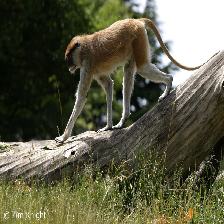

In [51]:
image = load_img(image_path[0], target_size = (224,224,3))
IPython.display.display(image)

In [66]:
#Prepared data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(data, Label, test_size = 0.2)
X_train = X_train_orig/255.0
X_test = X_test_orig/255.0
print("Number of training examples:  " + str(X_train.shape[0]))
print("Number of test examples:  " + str(X_test.shape[0]))
print("Dimension of training sample:  " + str(X_train.shape))
print("Dimension of label:  " + str(y_train_orig.shape))

Number of training examples:  1101
Number of test examples:  276
Dimension of training sample:  (1101, 224, 224, 3)
Dimension of label:  (1101, 10)


In [97]:
#Training step
model.fit(x = X_train, y = y_train_orig, validation_data = (X_test, y_test_orig), epochs = 10, batch_size = 32)

Epoch 1/10
35/35 [==============================] - 277s 8s/step - loss: 13.1930 - aux1_loss: 5.6148 - aux2_loss: 7.9158 - main_loss: 9.1339 - aux1_accuracy: 0.0881 - aux2_accuracy: 0.1054 - main_accuracy: 0.1008 - val_loss: 11.8749 - val_aux1_loss: 3.8278 - val_aux2_loss: 7.7658 - val_main_loss: 8.3968 - val_aux1_accuracy: 0.0652 - val_aux2_accuracy: 0.0978 - val_main_accuracy: 0.0978
Epoch 2/10
35/35 [==============================] - 275s 8s/step - loss: 12.4604 - aux1_loss: 3.5478 - aux2_loss: 7.7449 - main_loss: 9.0726 - aux1_accuracy: 0.0954 - aux2_accuracy: 0.0863 - main_accuracy: 0.0854 - val_loss: 11.8555 - val_aux1_loss: 3.7653 - val_aux2_loss: 7.7668 - val_main_loss: 8.3958 - val_aux1_accuracy: 0.0978 - val_aux2_accuracy: 0.0978 - val_main_accuracy: 0.0978
Epoch 3/10
35/35 [==============================] - 277s 8s/step - loss: 12.4527 - aux1_loss: 3.5370 - aux2_loss: 7.7393 - main_loss: 9.0698 - aux1_accuracy: 0.1072 - aux2_accuracy: 0.1117 - main_accuracy: 0.1090 - val_los

In [106]:
model_json = model.to_json()
with open("GoogleNet_architecture.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("GoogleNet_weights.h5")
print("Saved model to disk")

Saved model to disk


<function matplotlib.pyplot.show>

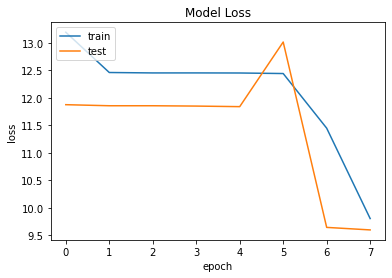

In [113]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc = "upper left")
plt.show

<function matplotlib.pyplot.show>

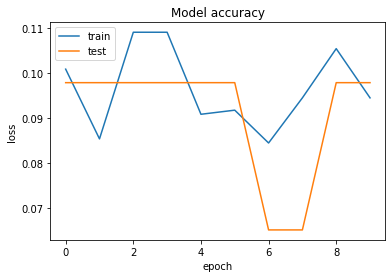

In [117]:
plt.plot(model.history.history["main_accuracy"])
plt.plot(model.history.history["val_main_accuracy"])
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc = "upper left")
plt.show

In [118]:
model.summary()

Model: "GoogleNet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_244 (Conv2D)             (None, 112, 112, 64) 9472        input_13[0][0]                   
__________________________________________________________________________________________________
activation_271 (Activation)     (None, 112, 112, 64) 0           conv2d_244[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_59 (MaxPooling2D) (None, 56, 56, 64)   0           activation_271[0][0]             
_______________________________________________________________________________________